In [1]:
#%pip install xgboost

In [2]:
# 1) Imports and helpers
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor


In [3]:
# 2) Load data and define target/feature sets
# Adjust the path to cleaned_listings.csv if it lives elsewhere.
df = pd.read_csv("../data/curated/rent_features/cleaned_listings.csv")

# Ensure the response is numeric; drop rows where it isn't available
df["weekly_rent"] = pd.to_numeric(df["weekly_rent"], errors="coerce")
df = df.dropna(subset=["weekly_rent"])

y = df["weekly_rent"]
X = df.drop(columns=["weekly_rent"])


/tmp/ipykernel_11984/351177666.py:3: DtypeWarning: Columns (16,17,18,20,22,23,25,26,32,34,35,36,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/curated/rent_features/cleaned_listings.csv")


In [1]:
# 3) Identify column types (categorical vs numeric)

# set categorical features
cat_cols = [
    'property_type', 'suburb', 'postcode',
    'agency_name', 'agent_name', 'appointment_only',
    'listing_status'
]

# set numerical features
num_cols = [
    'bedrooms', 'bathrooms', 'car_spaces',
    'land_area', 'year', 'quarter',
    'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus',
    'avg_days_on_market', 'family_percentage', 'long_term_resident', 
    'median_rent_price', 'median_sold_price', 'number_sold', 'renter_percentage',
    'single_percentage', 'best_score_driving_5min', 'best_score_driving_10min', 
    'best_score_driving_15min', 'best_score_walking_5min', 'best_score_walking_10min', 
    'best_score_walking_15min', 'best_dist_km_driving_5min', 'best_dist_km_driving_10min',
    'best_dist_km_driving_15min', 'best_dist_km_walking_5min', 'best_dist_km_walking_10min',
    'best_dist_km_walking_15min', 'n_schools_driving_5min', 'n_schools_driving_10min',
    'n_schools_driving_15min', 'n_schools_walking_5min', 'n_schools_walking_10min',
    'n_schools_walking_15min'
]

print(f"Categorical: {len(cat_cols)} | Numeric: {len(num_cols)}")

Categorical: 7 | Numeric: 36


In [5]:
# 4) Build the preprocessing transformer
# - Numeric: median imputation
# - Categorical: most-frequent imputation + one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop",
)


In [6]:
# 5) Split data into train/validation/test (60/20/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)  # 0.25 of 0.8 = 0.2 overall for validation


In [7]:
# 6) Fit the preprocessor on training data only; transform all splits

preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
X_val_t = preprocessor.transform(X_val)
X_test_t = preprocessor.transform(X_test)

# Get feature names for later importance inspection
feature_names = preprocessor.get_feature_names_out()


In [8]:
# 7) Define and train the XGBoost regressor with early stopping
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
)

xgb.fit(
    X_train_t,
    y_train,
    eval_set=[(X_val_t, y_val)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [9]:
# 8) Evaluate on the held-out test set with multiple metrics
preds = xgb.predict(X_test_t)

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
med_ae = median_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# MAPE can be problematic when y contains zeros; handle gracefully
try:
    mape = mean_absolute_percentage_error(y_test, preds)
except Exception:
    mape = np.nan

# Symmetric MAPE (robust to zeros)
smape = np.mean(
    2.0 * np.abs(preds - y_test) / (np.abs(y_test) + np.abs(preds) + 1e-12)
)

print(f"RMSE:   {rmse:,.2f}")
print(f"MAE:    {mae:,.2f}")
print(f"MedianAE: {med_ae:,.2f}")
print(f"R^2:    {r2:,.4f}")
print(f"MAPE:   {mape:.4f}")
print(f"sMAPE:  {smape:.4f}")


RMSE:   101.10
MAE:    66.69
MedianAE: 44.59
R^2:    0.6856
MAPE:   0.1183
sMAPE:  0.1107


In [10]:
# 9) Inspect top feature importances
imp = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb.feature_importances_,
}).sort_values("importance", ascending=False)

imp


,feature,importance
14,num__median_sold_price,0.024280
13,num__median_rent_price,0.014745
1023,cat__postcode_3205,0.007265
1000,cat__postcode_3181,0.007125
907,cat__postcode_3065,0.007107
...,...,...
2012,cat__agency_name_prd albury-wodonga,0.000000
2063,cat__agency_name_ray white bentleigh,0.000000
2064,cat__agency_name_ray white berwick,0.000000
2065,cat__agency_name_ray white blackburn,0.000000


In [11]:
# 9a) Inspect the top numerical feature importances
num_feature_mask = [name.startswith("num__") for name in imp['feature']]
imp_num = imp[num_feature_mask]
imp_num

,feature,importance
14,num__median_sold_price,0.024280
13,num__median_rent_price,0.014745
1,num__bathrooms,0.003539
15,num__number_sold,0.002515
4,num__year,0.001396
10,num__avg_days_on_market,0.001280
0,num__bedrooms,0.001257
17,num__single_percentage,0.000983
12,num__long_term_resident,0.000884
9,num__age_60_plus,0.000779


In [12]:
# 9b) Inspect the top categorical feature importances
cat_feature_mask = [name.startswith("cat__") for name in imp['feature']]
imp_cat = imp[cat_feature_mask]
imp_cat

,feature,importance
1023,cat__postcode_3205,0.007265
1000,cat__postcode_3181,0.007125
907,cat__postcode_3065,0.007107
1083,cat__postcode_3350,0.006931
693,cat__suburb_south melbourne,0.006682
...,...,...
2012,cat__agency_name_prd albury-wodonga,0.000000
2063,cat__agency_name_ray white bentleigh,0.000000
2064,cat__agency_name_ray white berwick,0.000000
2065,cat__agency_name_ray white blackburn,0.000000


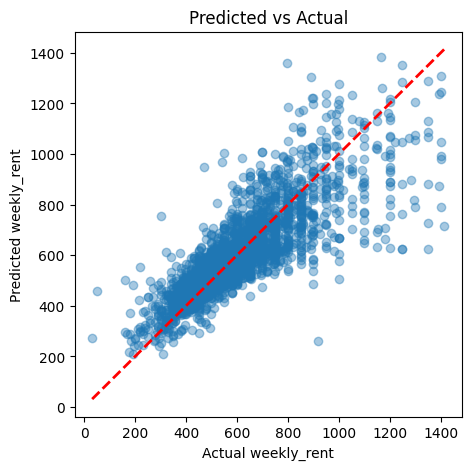

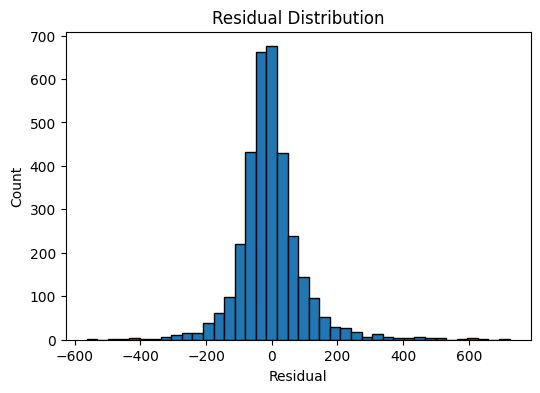

In [13]:
# 10) Optional: simple diagnostic plots (in a notebook)
import matplotlib.pyplot as plt

# Predicted vs Actual
plt.figure(figsize=(5,5))
plt.scatter(y_test, preds, alpha=0.4)
lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual weekly_rent")
plt.ylabel("Predicted weekly_rent")
plt.title("Predicted vs Actual")
plt.show()

# Residuals
residuals = y_test - preds
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, edgecolor="k")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()


## Optimised Model

In [14]:
from pathlib import Path
import json

metrics_path = Path("../models/xgboost/metrics.json")

In [15]:
import json
with open(metrics_path) as f:
    best_params = json.load(f)["best_params"]

best_params

{'regressor__subsample': 0.9,
 'regressor__reg_lambda': 0.251189,
 'regressor__reg_alpha': 0.000631,
 'regressor__n_estimators': 800,
 'regressor__min_child_weight': 5,
 'regressor__max_depth': 4,
 'regressor__learning_rate': 0.217,
 'regressor__gamma': 0.4,
 'regressor__colsample_bytree': 0.7}

In [16]:
# run xgbregressor again
optimised_xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_jobs=-1,
    random_state=42,
    **best_params,
)

In [17]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", optimised_xgb)
    ]
)

In [18]:
# 6) Fit on the full training portion (train + val) to match the tuning workflow
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

pipeline.fit(X_train_full, y_train_full)

/home/james/project-2-group-real-estate-industry-project-23-2025/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:37:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "regressor__colsample_bytree", "regressor__gamma", "regressor__learning_rate", "regressor__max_depth", "regressor__min_child_weight", "regressor__n_estimators", "regressor__reg_alpha", "regressor__reg_lambda", "regressor__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
# 7) Evaluate on test set
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
med_ae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE:    {rmse:,.2f}")
print(f"MAE:     {mae:,.2f}")
print(f"MedianAE:{med_ae:,.2f}")
print(f"R^2:     {r2:.4f}")


RMSE:    105.12
MAE:     70.15
MedianAE:47.35
R^2:     0.6601


In [ ]:
# TODO: Fix the optimised model

In [ ]:
# TODO: Standardise the data to get better results